28.77777777777778 6.508067168645767
Time t-test: t-statistic = 0.16, p-value = 0.8768


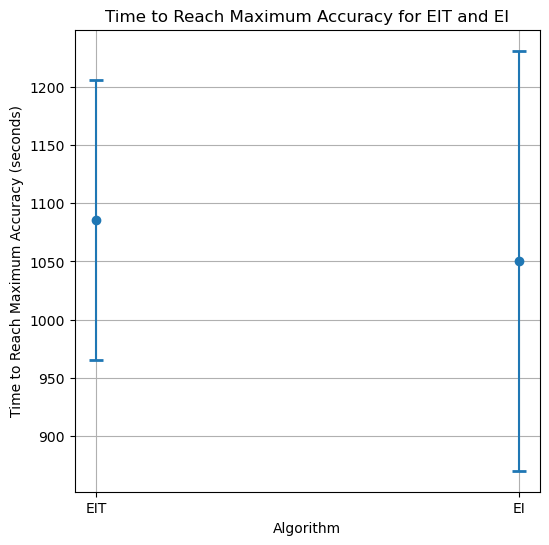

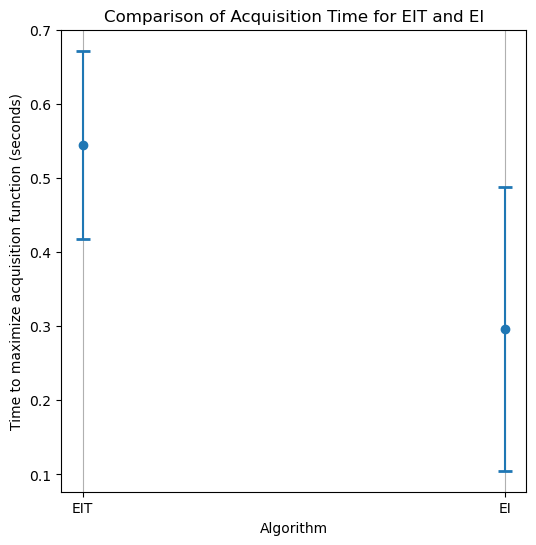

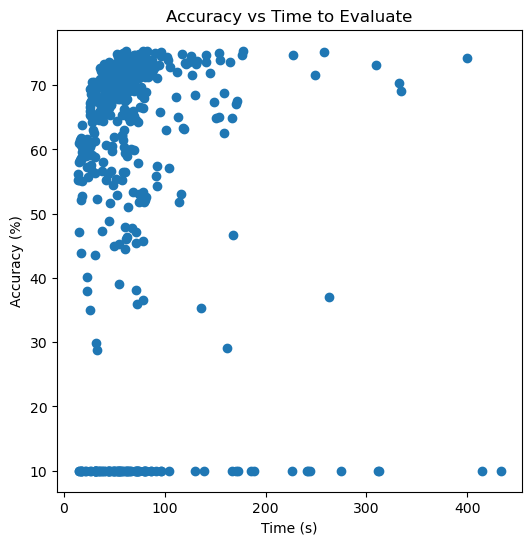

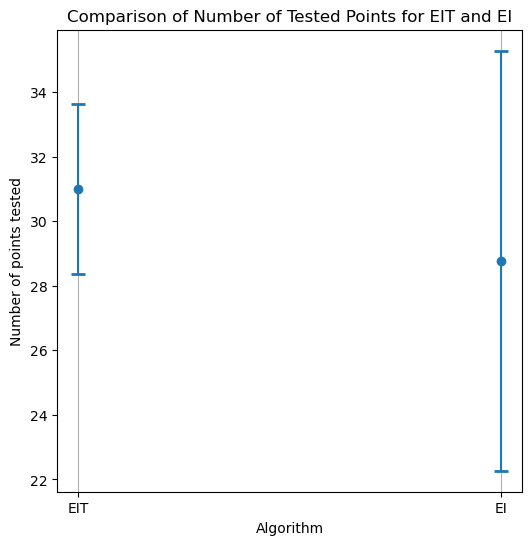

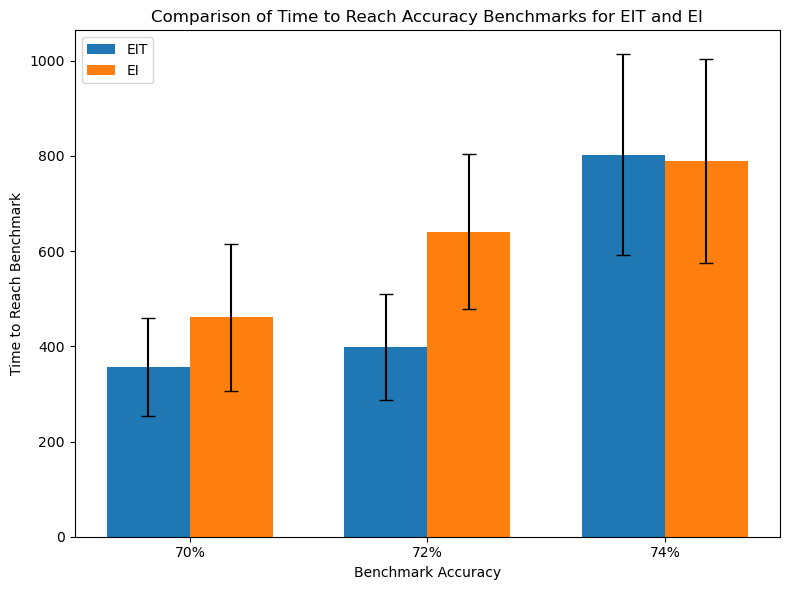

In [18]:
import pandas as pd
import ast
import re
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt


gfg_1 = pd.read_csv("data/GFG1_GPU.csv")
gfg_2 = pd.read_csv("data/GFG2_GPU.csv")
uncleaned_output = pd.concat([gfg_1, gfg_2], ignore_index=True)

# Initialize an empty DataFrame with the columns we want
cleaned = pd.DataFrame(columns=['Algorithm', 'Major Iteration', 'Minor Iteration', 'Running Time', 'Accuracy', 'Integration Time', 'Evaluation Time'])

# Iterate over the rows in the uncleaned output and extract the values
current_algorithm = None
current_major_iteration = 0
for index, row in uncleaned_output.iterrows():
    if 'Run' in row[0]:
        current_algorithm = re.sub(r'[^E,I,T]', '', row[0])
        if current_algorithm == "EIT":
            current_major_iteration += 1
    else:  # Skip header/label rows
        values = ast.literal_eval(row[0])
        cleaned.loc[index] = [
            current_algorithm,              # Algorithm
            current_major_iteration,          # Major Iteration
            values[0],          # Minor Iteration
            values[1],          # Time
            values[2],          # Accuracy
            values[3],          # Integration Time
            values[4],          # Evaluation Time
        ]
        
cleaned['Final'] = cleaned.groupby(['Algorithm', 'Major Iteration'])['Accuracy'].transform('max') == cleaned['Accuracy']
cleaned.to_csv('cleaned.csv', index=False)
# Function to calculate time to reach final accuracy for each major iteration
def time_to_max_accuracy(df):
    max_accuracy_idx = df[df['Final']].index.min()
    return df.loc[max_accuracy_idx, 'Running Time'] if not np.isnan(max_accuracy_idx) else np.nan

def time_to_given_accuracy(df, accuracy):
    max_accuracy_idx = df[df['Accuracy'] >= accuracy].index.min()
    return df.loc[max_accuracy_idx, 'Running Time'] if not np.isnan(max_accuracy_idx) else np.nan

# Calculate time to reach maximum accuracy for each major iteration
eit_times_to_max = cleaned[cleaned['Algorithm'] == 'EIT'].groupby('Major Iteration').apply(time_to_max_accuracy).dropna()
eit_time_mean, eit_time_std = eit_times_to_max.mean(), eit_times_to_max.std() / np.sqrt(len(eit_times_to_max))
ei_times_to_max = cleaned[cleaned['Algorithm'] == 'EI'].groupby('Major Iteration').apply(time_to_max_accuracy).dropna()
ei_time_mean, ei_time_std = ei_times_to_max.mean(), ei_times_to_max.std() / np.sqrt(len(ei_times_to_max))

#Plotting time to reach 70%, 72%, 74%
time_to_70_eit = cleaned[cleaned['Algorithm'] == "EIT"].groupby('Major Iteration').apply(time_to_given_accuracy, 70).dropna()
time_to_70_ei = cleaned[cleaned['Algorithm'] == "EI"].groupby('Major Iteration').apply(time_to_given_accuracy, 70).dropna()
time_to_72_eit = cleaned[cleaned['Algorithm'] == "EIT"].groupby('Major Iteration').apply(time_to_given_accuracy, 72).dropna()
time_to_72_ei = cleaned[cleaned['Algorithm'] == "EI"].groupby('Major Iteration').apply(time_to_given_accuracy, 72).dropna()
time_to_74_eit = cleaned[cleaned['Algorithm'] == "EIT"].groupby('Major Iteration').apply(time_to_given_accuracy, 74).dropna()
time_to_74_ei = cleaned[cleaned['Algorithm'] == "EI"].groupby('Major Iteration').apply(time_to_given_accuracy, 74).dropna()

# Calculate means and standard errors
means_eit = [time_to_70_eit.mean(), time_to_72_eit.mean(), time_to_74_eit.mean()]
means_ei = [time_to_70_ei.mean(), time_to_72_ei.mean(), time_to_74_ei.mean()]
stderr_eit = [time_to_70_eit.std() / np.sqrt(len(time_to_70_eit)), 
              time_to_72_eit.std() / np.sqrt(len(time_to_72_eit)), 
              time_to_74_eit.std() / np.sqrt(len(time_to_74_eit))]
stderr_ei = [time_to_70_ei.std() / np.sqrt(len(time_to_70_ei)), 
             time_to_72_ei.std() / np.sqrt(len(time_to_72_ei)), 
             time_to_74_ei.std() / np.sqrt(len(time_to_74_ei))]

# Calculate time to integrate on average
eit_time_to_integrate = cleaned[cleaned['Algorithm'] == 'EIT']['Integration Time']
eit_integrate_mean = eit_time_to_integrate.mean()
eit_integrate_std = eit_time_to_integrate.std() 
ei_time_to_integrate = cleaned[cleaned['Algorithm'] == 'EI']['Integration Time']
ei_integrate_mean = ei_time_to_integrate.mean()
ei_integrate_std = ei_time_to_integrate.std()

#Calculate number of points tested for each algorithm, on average
eit_points_tested = cleaned[cleaned['Algorithm'] == 'EIT'].groupby('Major Iteration').size()
ei_points_tested = cleaned[cleaned['Algorithm'] == 'EI'].groupby('Major Iteration').size()
eit_points_tested_mean = eit_points_tested.mean()
ei_points_tested_mean = ei_points_tested.mean()
eit_points_tested_std = eit_points_tested.std() / np.sqrt(len(eit_points_tested))
ei_points_tested_std = ei_points_tested.std() / np.sqrt(len(ei_points_tested))
print(ei_points_tested_mean, ei_points_tested_std)


# Perform t-test for time to reach maximum accuracy
t_stat_time, p_value_time = ttest_ind(eit_times_to_max, ei_times_to_max)
print(f"Time t-test: t-statistic = {t_stat_time:.2f}, p-value = {p_value_time:.4f}")


# Plot time to reach maximum accuracy comparison with error bars
plt.figure(figsize=(6, 6))
plt.errorbar(['EIT', 'EI'], [eit_time_mean, ei_time_mean], yerr=[eit_time_std, ei_time_std], fmt='o', capsize=5, capthick=2, linewidth=1.5)
plt.title('Time to Reach Maximum Accuracy for EIT and EI')
plt.xlabel('Algorithm')
plt.ylabel('Time to Reach Maximum Accuracy (seconds)')
plt.grid(True)
plt.show()

# Plot Average Integration Time
plt.figure(figsize=(6, 6))
plt.errorbar(['EIT', 'EI'], [eit_integrate_mean, ei_integrate_mean], yerr=[eit_integrate_std, ei_integrate_std], fmt='o', capsize=5, capthick=2, linewidth=1.5)
plt.title('Comparison of Acquisition Time for EIT and EI')
plt.xlabel('Algorithm')
plt.ylabel('Time to maximize acquisition function (seconds)')
plt.grid(axis = 'x')
plt.show()

#Comparing accuracy vs time to evaluate
plt.figure(figsize=(6, 6))
plt.scatter(cleaned['Evaluation Time'], cleaned['Accuracy'])
plt.xlabel('Time (s)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Time to Evaluate')
plt.show()


# Plot Average Number of points tested
plt.figure(figsize=(6, 6))
plt.errorbar(['EIT', 'EI'], [eit_points_tested_mean, ei_points_tested_mean], yerr=[eit_points_tested_std, ei_points_tested_std], fmt='o', capsize=5, capthick=2, linewidth=1.5)
plt.title('Comparison of Number of Tested Points for EIT and EI')
plt.xlabel('Algorithm')
plt.ylabel('Number of points tested')
plt.grid(axis = 'x')
plt.show()


bar_width = 0.35

# X positions for the bars
index = np.arange(3)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot bars for EIT
plt.bar(index, means_eit, bar_width, yerr=stderr_eit, capsize=5, label='EIT')

# Plot bars for EI
plt.bar(index + bar_width, means_ei, bar_width, yerr=stderr_ei, capsize=5, label='EI')

# Add some text for labels, title and axes ticks
plt.xlabel('Benchmark Accuracy')
plt.ylabel('Time to Reach Benchmark (s)')
plt.title('Comparison of Time to Reach Accuracy Benchmarks for EIT and EI')
plt.xticks(index + bar_width / 2, ['70%', '72%', '74%'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



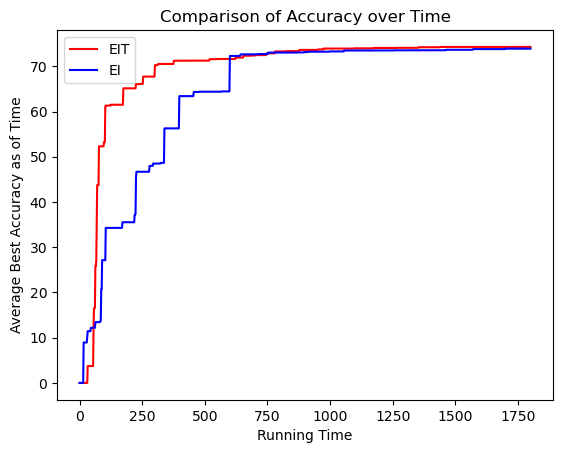

In [19]:
times = np.linspace(0, 1800, 1000)
eit_accuracies = []
ei_accuracies = []
max_major_iteration = cleaned['Major Iteration'].max()
for time in times:
    eit_accuracies_time = []
    ei_accuracies_time = []
    for iteration in range(1, int(max_major_iteration + 1)):
        best_eit_accuracy = cleaned[(cleaned['Algorithm'] == 'EIT') & (cleaned['Major Iteration'] == iteration) & 
                                    (cleaned['Running Time'] <= time)]['Accuracy'].max()
        if np.isnan(best_eit_accuracy):
            eit_accuracies_time.append(0)
        else:
            eit_accuracies_time.append(best_eit_accuracy)
            
        best_ei_accuracy = cleaned[(cleaned['Algorithm'] == 'EI') & (cleaned['Major Iteration'] == iteration) & 
                                   (cleaned['Running Time'] <= time)]['Accuracy'].max()
        
        if np.isnan(best_ei_accuracy):
            ei_accuracies_time.append(0)
        else:
            ei_accuracies_time.append(best_ei_accuracy)
    eit_accuracies.append(np.mean(eit_accuracies_time))
    ei_accuracies.append(np.mean(ei_accuracies_time))

# Add labels and title
plt.plot(times, eit_accuracies, label='EIT', color = 'red')
plt.plot(times, ei_accuracies, label='EI', color = 'blue')
plt.xlabel('Running Time (s)')
plt.ylabel('Average Best Accuracy as of Time')
plt.title('Comparison of Accuracy over Time')
plt.legend()

# Show the plot
plt.show()